# Benchmark: PXD024043 - Proteins

This notebook contains code to benchmark the model on the [PXD024043 dataset](https://www.ebi.ac.uk/pride/archive/projects/PXD024043) - cell cycle proteomes. 
Four cell populations enriched in different cell cycle stages were produced from HeLa cells by drug treatment.
Here, we'll use the protein dataset. Download the zip-file, "DIANN1.8_SingleCells_CellCycle.zip" and locate the file, "20210919_DIANN_SingleCellOutput.pg_matrix.tsv".

Let's start with the imports.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc


import scvi  # noqa: I001
from protvi.model import PROTVI

from protvi.evaluation import (
    plots as pl,
    simulations as sm, 
    benchmark_models as bm
)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)
scvi.settings.seed = 42

Seed set to 42


In [4]:
adata = sc.read("../../../data/processed/brunner2022.h5ad")

In [5]:
m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.08, mnar_proportion=1, x=adata.layers["raw"], seed=42)

In [6]:
print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

MNAR: 0.041, MCAR: 0.000


In [7]:
train_mask = ~(m_mcar | m_mnar)

sm.add_train_test_set(adata, train_mask, layer="raw")

## PROTVI

### Training

Let's now train the model.

In [6]:
adata.X = adata.layers["train"].copy()
adata.X[np.isnan(adata.X)] = 0

In [7]:
PROTVI.setup_anndata(adata) #, batch_key="coarse_condition")

model = PROTVI(adata, log_variational=False,  n_hidden=32, decoder_type="selection")
#model.view_anndata_setup()

Let's train the model.

In [8]:
model.train(max_epochs=100, plan_kwargs={"mechanism_weight": 0.1, "lr": 2e-3}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 6, "max_kl_weight": 6})
#model.train(max_epochs=4000, plan_kwargs={"mechanism_weight": 0.1, "lr": 2e-3}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 6, "max_kl_weight": 6})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 13.01it/s, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=2.76e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=2.76e+3]


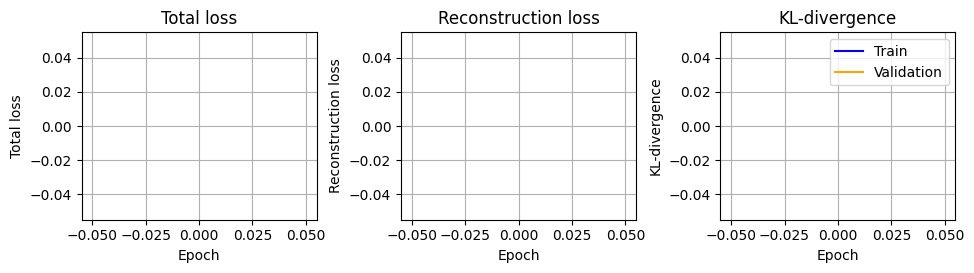

In [18]:
pl.plot_loss(model.history, epoch_start=200)

### Evaluation on training set

In [10]:
x_est, p_est = model.impute(n_samples=100, loss_type="iwae")

In [11]:
x_test = adata.layers["test"]

x_guess = x_est.copy()
x_guess[np.isnan(x_test)] = np.nan

x_true = x_test.copy()

In [12]:
mse_test = _metrics.mse(x_guess[~np.isnan(x_test)], x_true[~np.isnan(x_test)])
print(f"Test MSE: {mse_test:.4f}")

Test MSE: 5.0060


Text(0.5, 1.0, 'Imputation accuracy (MSE: 5.0060)')

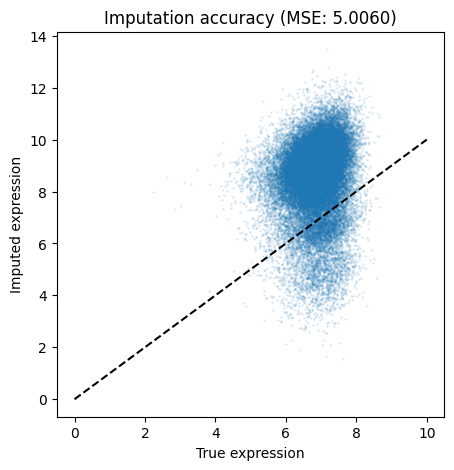

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot([0, 10], [0, 10], ls="--", c="black")
ax.scatter(x_true, x_guess, s=1, alpha=0.1)
ax.set_xlabel("True expression")
ax.set_ylabel("Imputed expression")
ax.set_title(f"Imputation accuracy (MSE: {mse_test:.4f})")

In [29]:
adata.layers["knn"] = bm.impute_knn(adata, layer="train")
x_min = np.nanmin(adata.layers["train"])
adata.layers["knn"][np.isnan(adata.layers["knn"])] = x_min

mask = ~np.isnan(x_true)
mse_test = _metrics.mse(adata.layers["knn"][mask], x_true[mask])

print(f"Test MSE: {mse_test:.4f}")

Test MSE: 0.3049
